# 第5讲-机器学习基础-3-决策树和集成学习

## 目录
- 决策树学习
    - 构建一颗决策树
    - 可视化一颗决策树
    - 不同的impurity criteria
    - 利用Python实现二分决策树
- 通过随机森林将弱学习器变成强学习器

- ensembles-集成学习
    - 投票分类器
        - VotingClassifier in Sklearn
        - 利用投票进行不同的分类算法的组合
        - 评估集成分类器
    - Bagging -- 利用bootstrap抽样构建集成分类器
    - 通过adaptive boosting构建集成学习器
- 其它算法实现（手动实现的参考）

<br>
<br>

# 决策树

[[back to top](#目录)]

下面将描述一系列基于决策树的学习算法。决策树的动机很简单。就是一些列的选择（if， else）。类似一个人类做决策。

但是如何做决策，提出什么问题，怎么回答这些，决策树则是基于对数据的学习


比如，你要建议一套规则来识别自然界的某种动物，你可能会提出如下问题：

- 这个动物体长有一米吗？
 + 比一米长：这个动物有角吗？
  - 有：这个角比10厘米长吗？
  - 没有：这些动物会佩戴项圈吗？
 + 比一米短：这个动物两条腿还是四条腿？
  - 两条：有翅膀吗？
  - 四条：有毛茸茸的尾巴吗？

等等等等问题。

而如何提出问题来进行分裂，是决策树的关键（考虑：一个好问题直接给出答案？）

<hr>



基于树的模型的一大优点是，极少的数据预处理（或者对数据的形态要求极少）。而且可以应付各类数据（离散的，连续的），而且不用对特征做标准化之类的动作。

另外一个主要的优点是，基于树的方法是“非参数”的。这意味着它们不需要学习一组特定的参数。反之，只要数据量足够，树模型非常自由。随着数据量的增大，参数可以不断增多，不需要受限制（考虑线性模型这样事先规定好“模型”的模型）

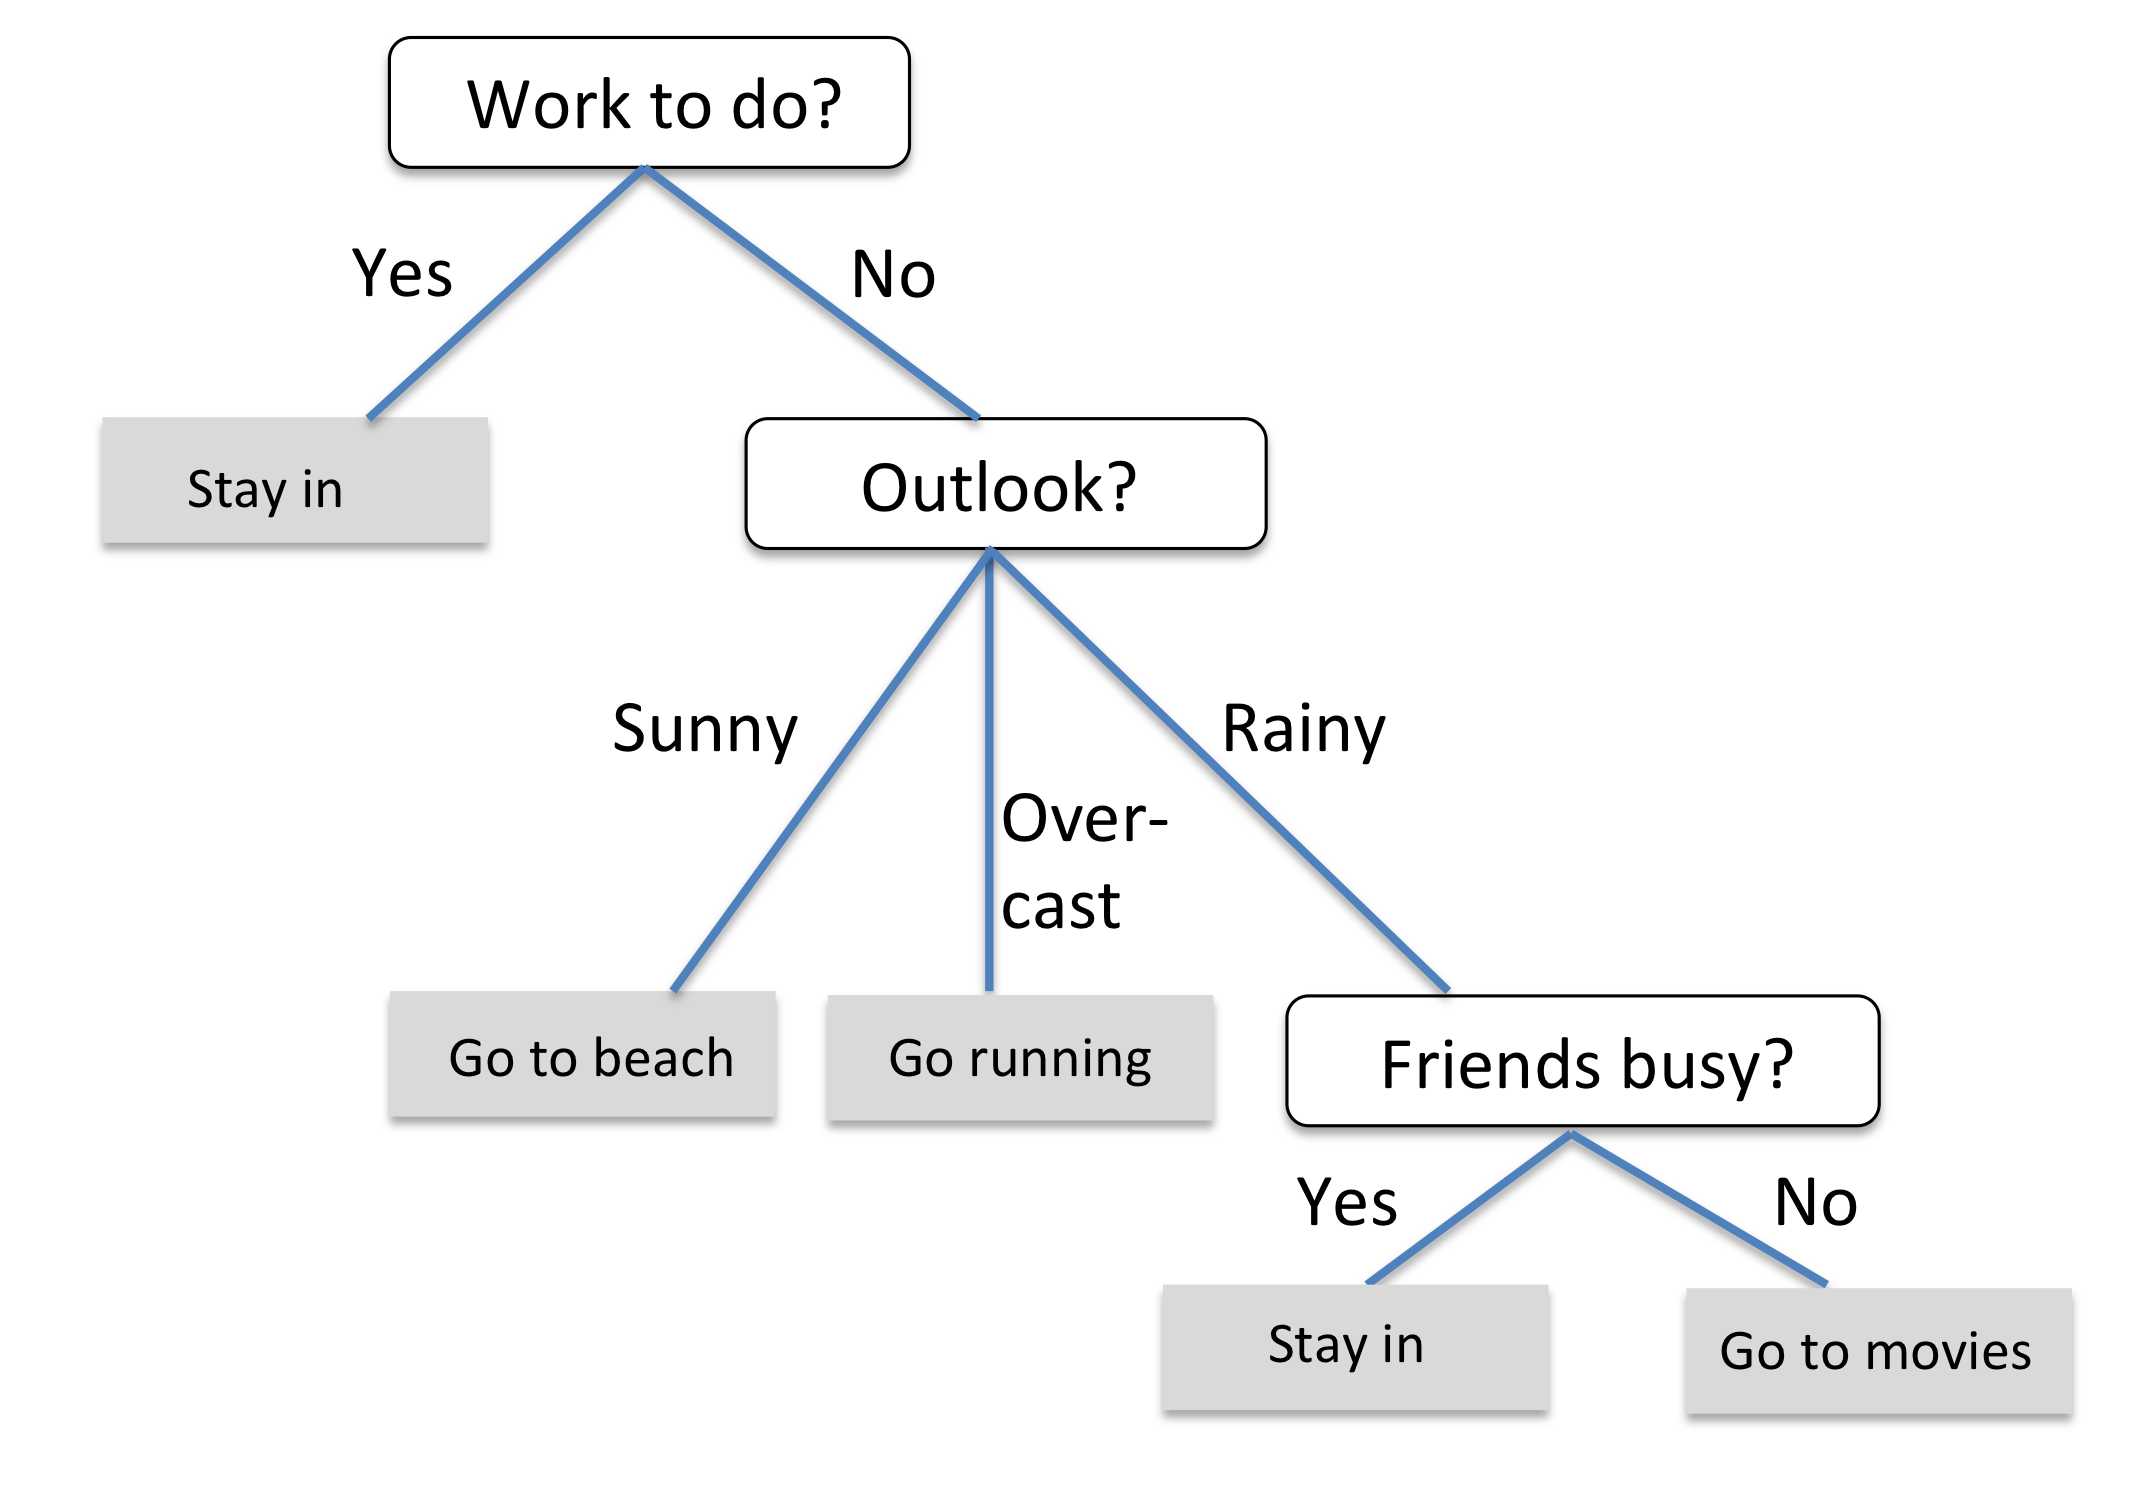

In [1]:
from IPython.display import Image
Image(filename='pic_dir/03_15.png', width=700)

<br>
<br>

## 先看一颗回归树

## 再构建一棵分类树

[[back to top](#目录)]

In [2]:
import numpy as np
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

iris = datasets.load_iris()
X = iris.data[:, [2, 3]]
y = iris.target

X_train, X_test, y_train, y_test = train_test_split(
         X, y, test_size=0.3, random_state=0)

sc = StandardScaler()
sc.fit(X_train)
X_train_std = sc.transform(X_train) # standardize by mean & std
X_test_std = sc.transform(X_test)

In [6]:
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt
%matplotlib inline

def plot_decision_regions(X, y, classifier, test_idx=None, resolution=0.02):

    # setup marker generator and color map
    markers = ('s', 'x', 'o', '^', 'v')
    colors = ('red', 'blue', 'lightgreen', 'gray', 'cyan')
    cmap = ListedColormap(colors[:len(np.unique(y))])

    # plot the decision surface
    x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution),
                         np.arange(x2_min, x2_max, resolution))
    Z = classifier.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
    Z = Z.reshape(xx1.shape)
    plt.contourf(xx1, xx2, Z, alpha=0.4, cmap=cmap)
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())

    # 画出所有样本
    for idx, cl in enumerate(np.unique(y)):
        plt.scatter(x=X[y == cl, 0], y=X[y == cl, 1],
                    alpha=0.8, c=cmap(idx),
                    marker=markers[idx], label=cl)
        
    # 画出测试样本
    if test_idx:
        X_test, y_test = X[test_idx, :], y[test_idx]   
        plt.scatter(X_test[:, 0], X_test[:, 1], c='', 
                alpha=1.0, linewidth=1, marker='o', 
                s=55, label='test set')

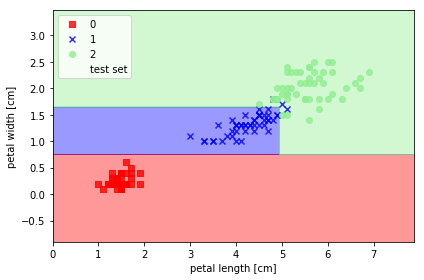

In [8]:
from sklearn.tree import DecisionTreeClassifier
# 调用sklearn的决策树方法，max_depth为3，不纯度量为entropy
tree = DecisionTreeClassifier(criterion='entropy', max_depth=3, random_state=0)
tree.fit(X_train, y_train)

X_combined = np.vstack((X_train, X_test))
y_combined = np.hstack((y_train, y_test))
plot_decision_regions(X_combined, y_combined, 
                      classifier=tree, test_idx=range(105,150))

plt.xlabel('petal length [cm]')
plt.ylabel('petal width [cm]')
plt.legend(loc='upper left')
plt.tight_layout()
# plt.savefig('./figures/decision_tree_decision.png', dpi=300)

<br>
<br>

## *可视化一颗决策树

scikit-learn中决策树的可视化一般需要安装graphviz

主要包括graphviz的安装和python的graphviz插件的安装。

1. 安装graphviz，http://www.graphviz.org
 - linux，apt-get或者yum的方法安装
 - windows，官网下载msi文件安装
 - 设置环境变量，将graphviz的bin目录加到PATH

2. 安装python插件graphviz： pip install graphviz

3. 安装python插件pydotplus：pip install pydotplus

4. if还是找不到graphviz，添加：os.environ["PATH"] += os.pathsep + 'C:/Graphviz/bin/'

[[back to top](#目录)]

In [8]:
from  sklearn.tree import DecisionTreeClassifier

In [5]:
# pip install pydotplus
import pydotplus

In [9]:
from sklearn.tree import export_graphviz
# 将树输出为.dot文件，需要安装GraphViz工具进行转换
# export_graphviz(tree, 
#                 out_file='tree.dot', 
#                 feature_names=['petal length', 'petal width'])

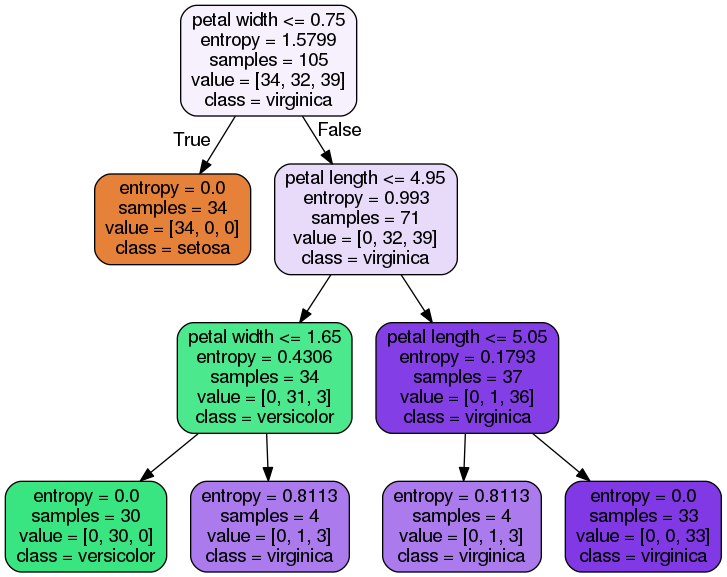

In [10]:
from IPython.display import Image
from IPython.display import display

dot_data = export_graphviz(
    tree, 
    out_file=None,
    # the parameters below are new in sklearn 0.18
    feature_names=['petal length', 'petal width'],  
    class_names=['setosa', 'versicolor', 'virginica'],  
    filled=True,
    rounded=True)

graph = pydotplus.graph_from_dot_data(dot_data)  
display(Image(graph.create_png()))

<br>
<br>

## 讨论不同的impurity criteria

[[back to top](#目录)]

entropy（熵）：表示随机变量不确定性的度量。设X是一个取有限个值得离散随机变量，其概率分布为：

$P(X = x_i)=p_i$

$entropy = -\sum(p_i log(p_i))$

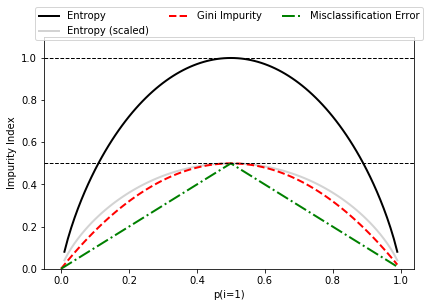

In [5]:
def gini(p):
    return (p)*(1 - (p)) + (1-p)*(1 - (1-p))

def entropy(p):
    return - p*np.log2(p) - (1 - p)*np.log2((1 - p))

def error(p):
    return 1 - np.max([p, 1 - p])

x = np.arange(0.0, 1.0, 0.01)

ent = [entropy(p) if p != 0 else None for p in x]
sc_ent = [e*0.5 if e else None for e in ent]
err = [error(i) for i in x]


fig = plt.figure()
ax = plt.subplot(111)
for i, lab, ls, c, in zip([ent, sc_ent, gini(x), err], 
                  ['Entropy', 'Entropy (scaled)', 
                   'Gini Impurity', 'Misclassification Error'],
                  ['-', '-', '--', '-.'],
                  ['black', 'lightgray', 'red', 'green', 'cyan']):
    line = ax.plot(x, i, label=lab, linestyle=ls, lw=2, color=c)


# 画图
ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.15),
          ncol=3, fancybox=True, shadow=False)

ax.axhline(y=0.5, linewidth=1, color='k', linestyle='--')
ax.axhline(y=1.0, linewidth=1, color='k', linestyle='--')
plt.ylim([0, 1.1])
plt.xlabel('p(i=1)')
plt.ylabel('Impurity Index')
plt.tight_layout()
# plt.savefig('./figures/impurity.png', dpi=300, bbox_inches='tight')

notes：

1. 决策树算法三个重要因素：
 - 特征选择
 - 决策树生成
 - 决策树剪枝

2. 不同的算法实现对特征选择的准则是不一样的（不纯度）
 - 信息增益（ID3算法）
 - 信息增益比（C4.5算法）
 - 基尼指数（CART算法）
 
3. 树的层次（越深越好？越浅越好）

<br>
<br>

## *使用Python实现二分决策树

[[back to top](#目录)]

In [6]:
from collections import Counter
import numpy as np


# 构建一个类，来表征二分树的结构
# Tree 里的属性除了包括左右节点的 Tree 之外，还有此节点中包括数据的标签及其熵值，
# 然后还有要切分 feature 的 idex
class Tree:
    """ Binary Tree"""
    def __init__(self, labels, split_idx=None,children_left=None, children_right=None):
        self.children_left = children_left
        self.children_right = children_right
        self.labels = labels
        self.split_idx = split_idx
        self.entropy = calc_entropy(self.labels)

    def predict(self):
        most_freq = np.bincount(self.labels).argmax()  # 找到最高频的元素，“投票”
        return most_freq

    def __repr__(self, level=0):
        """ make it easy to visualize a tree"""
        prefix = "\t" * level
        string = prefix + "entropy = {}, labels = {}, [0个数, 1个数] = {}\n".format(
            self.entropy, self.labels, np.bincount(self.labels, minlength=2))
        if self.split_idx is not None:
            string += prefix + "split on Column {}\n".format(self.split_idx)
            string += prefix + "True:\n"
            string += self.children_left.__repr__(level+1)
            string += prefix + "False:\n"
            string += self.children_right.__repr__(level+1)
        return string


# 计算一组数据里的熵值
def calc_entropy(labels):
    """ calculate entropy from an array of labels"""
    size = float(len(labels))
    cnt = Counter(labels)
    entropy = 0
    for label in set(labels):
        prob = cnt[label] / size
        entropy += -1 * prob * np.log2(prob)
    return entropy


# 不同的决策树算法 (如 ID3, C4.5, CART 等) 会用不同的标准来选择要切分的 feature
# 这里使用的是 Information Gain，即 feature 切分前后的熵值变化
def choose_best_feature_to_split(features, labels):
    """选择信息增益最大的特征作为最优劈裂点"""
    num_features = features.shape[1]
    base_entropy = calc_entropy(labels)

    best_info_gain = 0 
    best_feature = None

    for i in range(num_features):
        new_entropy = 0
        for value in [0, 1]:
            new_labels = labels[features[:, i] == value]
            weight = float(len(new_labels)) / len(labels)
            new_entropy += weight * calc_entropy(new_labels)
        info_gain = base_entropy - new_entropy
        if info_gain > best_info_gain:
            best_info_gain = info_gain
            best_feature = i
    return best_feature


def create_decision_tree(features, labels,current_depth=0, max_depth=10):
    """递归建树"""
    tree = Tree(labels)

    # 定义停止条件，当在某节点上的所有数据都是一类，就停止
    if len(set(labels)) == 1:
        return tree
    # 当最大深度达到，也停止
    if current_depth >= max_depth:
        return tree

    # 在找到的最优特征上分裂
    best_feature = choose_best_feature_to_split(features, labels)
    if best_feature is None:
        return tree
    
    # 递归构建子树
    msk = (features[:, best_feature] == 1)
    tree.split_idx = best_feature
    tree.children_left = create_decision_tree(
        features[msk], labels[msk], current_depth+1)
    tree.children_right = create_decision_tree(
        features[~msk], labels[~msk], current_depth+1)
    return tree

In [7]:
# 模拟一组数据来测试
data = np.array([[1, 0],
                 [1, 1],
                 [0, 1],
                 [0, 0]])
labels = np.array([1, 0, 0, 0])


tree = create_decision_tree(data, labels)

In [8]:
tree

entropy = 0.8112781244591328, labels = [1 0 0 0], [0个数, 1个数] = [3 1]
split on Column 0
True:
	entropy = 1.0, labels = [1 0], [0个数, 1个数] = [1 1]
	split on Column 1
	True:
		entropy = 0.0, labels = [0], [0个数, 1个数] = [1 0]
	False:
		entropy = 0.0, labels = [1], [0个数, 1个数] = [0 1]
False:
	entropy = 0.0, labels = [0 0], [0个数, 1个数] = [2 0]

In [9]:
# 遍历二分树，来得到分类预测
# 一个数据
def _classify(tree, data_row):
    """对新数据进行预测"""
    if tree.split_idx is None: # 是不是叶子节点，是的话，直接predict
        return tree.predict()
    
    split_idx = tree.split_idx
    if data_row[split_idx]:  # 分裂条件是否为True，满足分裂条件，往左；不然，往右（比如颜色是1，往左，不然，往右）
        return _classify(tree.children_left, data_row)
    else:
        return _classify(tree.children_right, data_row)
# 所有数据    
def classify(tree, data):
    data = np.array(data)
    num_row = data.shape[0]
    results = np.empty(shape=num_row)
    for i in range(num_row):
        results[i] = _classify(tree, data[i, :])
    return results

In [10]:
new_data = [[0, 0],
            [1, 0]]

classify(tree, new_data)

array([ 0.,  1.])

# ensembles集成学习

将一系列分类器集合起来, 取多数为分类结果

Build powerful models from weak learners that learn from their mistakes

ensemble method 就是讲多个不同的分类器集合组合为一个大的分类器. 选择最终结果是以 majority voting

即使每个单独的分类器错误率较高, 但将多个分类器组合之后, 错误率就会大大降低

[[back to top](#目录)]

假设我们组合了 n 个分类器，它们的错误率都为 $ \varepsilon $, 各个分类器之间独立。  
则这 n 个分类器里, 多于 k 个分类器分类错误的概率为
$$ P(y \geq k) = \sum^n_k \binom{n}{k} \varepsilon^k (1-\varepsilon)^{n-k}$$

In [13]:
# 0.4错误率
# 5个分错
from scipy.misc import comb
comb(9,5)*(0.4**5)*(0.6**4)

0.16721510400000003

In [14]:
[comb(9,k)*(0.4**5)*(0.6**4) for k in range(5,10)]

[0.16721510400000003,
 0.11147673600000002,
 0.047775744000000009,
 0.011943936000000002,
 0.0013271040000000002]

In [15]:
# 0.4错误率
# 大于5个分错
import numpy as np
np.sum(comb(9,k)*(0.4**5)*(0.6**4) for k in range(5,10))

0.33973862400000004

In [16]:
from scipy.misc import comb
import math

# emsemble error rate
def ensemble_error(n_classifier, error):
    k_start = int(math.ceil(n_classifier / 2.0))
    probs = [comb(n_classifier, k) * error**k * 
               (1-error)**(n_classifier - k) 
             for k in range(k_start, n_classifier + 1)]
    return sum(probs)

In [17]:
# 11个分类器, 每个分类器的 error rate 是0.25的话, 通过 combinator 之后的 error rate
ensemble_error(n_classifier=11, error=0.25)

0.034327507019042969

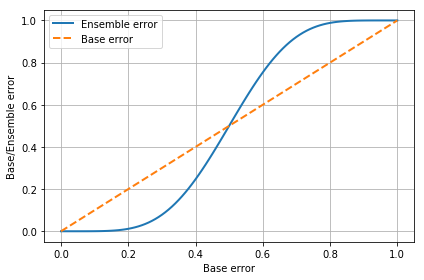

In [18]:
# ensemble error 和 base error 的关系
error_range = np.arange(0.0, 1.01, 0.01)
ens_errors = [ensemble_error(n_classifier=11, error=error) 
              for error in error_range]

plt.plot(error_range, ens_errors, 
         label='Ensemble error', linewidth=2)

plt.plot(error_range, error_range, 
         linestyle='--', label='Base error',linewidth=2)

plt.xlabel('Base error')
plt.ylabel('Base/Ensemble error')
plt.legend(loc='upper left')
plt.grid()
plt.tight_layout()
# plt.savefig('./figures/ensemble_err.png', dpi=300)

$\varepsilon$ < 0.5 时, emsemble error 都要低于 base error, $\varepsilon$ > 0.5 时, emsemble error 就会大于 base error

<br>
<br>

# 投票分类

combine different classication algorithms associated with individual weights for confidence

[[back to top](#目录)]

当多个分类器 C 拥有相同权重时，ensemble 给出的预测 $\hat y$ 为众数：
$$ \hat y = mode\{C_1(x), C_2(x), \dotso, C_m(x)\} $$

若分类器 $C_j$ 对应不同的权重 $w_j$, 则
$$ \hat y = \arg\max_i \sum^m_{j=1}w_j P_{ij} $$
其中 $P_{ij}$ 是 $C_j$ 预测结果为 i 的概率

In [19]:
import numpy as np
np.argmax(np.bincount([0, 0, 1], weights=[0.2, 0.2, 0.6]))

# np.argmax: returns the indices of the maximum values along an axis.
# np.bincount: Count number of occurrences of each value in array of non-negative ints

1

In [20]:
np.bincount([0, 0, 1], weights=[0.2, 0.2, 0.6])

array([ 0.4,  0.6])

In [21]:
ex = np.array([[0.9, 0.1],  # Classifier-1 的预测结果
               [0.8, 0.2],  # Classifier-2 的预测结果
               [0.4, 0.6]]) # Classifier-3 的预测结果

p = np.average(ex, 
               axis=0, 
               weights=[0.2, 0.2, 0.6])  # C1, C2, C3 的权重
p

array([ 0.58,  0.42])

$$p(i_0| x) = 0.58$$
$$p(i_1 | x) = 0.42$$
$$\hat y = \arg\max_i [p(i_0 | x), p(i_1 | x)] = 0$$

In [22]:
np.argmax(p) # return index

0

<br>
<br>

## VotingClassifier in Sklearn
使用 Sklearn 中自带的 [VotingClassifier](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.VotingClassifier.html)

[[back to top](#目录)]

In [23]:
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier

# 使用 3 个分类器
clf1 = LogisticRegression(random_state=1)
clf2 = RandomForestClassifier(random_state=1)
clf3 = GaussianNB()

# 生成数据
X = np.array([[-1, -1], [-2, -1], [-3, -2], [1, 1], [2, 1], [3, 2]])
y = np.array([1, 1, 1, 2, 2, 2])

# voting='hard', 使用预测的class作为直接投票
eclf1 = VotingClassifier(estimators=[
        ('lr', clf1), ('rf', clf2), ('gnb', clf3)], voting='hard')
eclf1 = eclf1.fit(X, y)
print(eclf1.predict(X))

# voting='soft', predicts the class label based on the argmax of the sums of the predicted probalities 
# voting='soft', 基于argmax的预测概率的sum作为投票
eclf2 = VotingClassifier(estimators=[
        ('lr', clf1), ('rf', clf2), ('gnb', clf3)],
        voting='soft')
eclf2 = eclf2.fit(X, y)
print(eclf2.predict(X))

# add weight
eclf3 = VotingClassifier(estimators=[
       ('lr', clf1), ('rf', clf2), ('gnb', clf3)],
       voting='soft', weights=[2,1,1])
eclf3 = eclf3.fit(X, y)
print(eclf3.predict(X))

[1 1 1 2 2 2]
[1 1 1 2 2 2]
[1 1 1 2 2 2]


In [13]:
#可以更自由，见后面的案例

<br>
<br>

## 对不同分类算法进行投票（实际数据）

[[back to top](#目录)]

In [24]:
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder

# load iris data
iris = datasets.load_iris()
X, y = iris.data[50:, [1, 2]], iris.target[50:]

st = StandardScaler()
X = st.fit_transform(X)

le = LabelEncoder()
y = le.fit_transform(y)

# 50% train, 50% test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=1)

In [25]:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score

clf1 = LogisticRegression(C=0.01, random_state=42)
clf2 = KNeighborsClassifier(n_neighbors=1)
clf3 = DecisionTreeClassifier(max_depth=1, random_state=42)

clf_labels = ['Logistic Regression', 'KNN', 'Decision Tree']
all_clf = [clf1, clf2, clf3]

print('10-fold cross validation:\n')
# 采样了交叉验证
for clf, label in zip(all_clf, clf_labels):
    scores = cross_val_score(estimator=clf, X=X_train, y=y_train,
                             cv=10, scoring='roc_auc')
    print("ROC AUC: %0.2f (+/- %0.2f) [%s]"
             % (scores.mean(), scores.std(), label))

10-fold cross validation:

ROC AUC: 0.93 (+/- 0.15) [Logistic Regression]
ROC AUC: 0.93 (+/- 0.10) [KNN]
ROC AUC: 0.92 (+/- 0.15) [Decision Tree]


In [26]:
from sklearn.ensemble import VotingClassifier

mv_clf = VotingClassifier(
    estimators=[('c1', clf1), ('c2', clf2), ('c3', clf3)], voting='soft')

clf_labels += ['Majority Voting']
all_clf += [mv_clf]

print('10-fold cross validation:\n')
for clf, label in zip(all_clf, clf_labels):
    scores = cross_val_score(estimator=clf, X=X_train, y=y_train,
                             cv=10, scoring='roc_auc')
    print("ROC AUC: %0.2f (+/- %0.2f) [%s]"
             % (scores.mean(), scores.std(), label))

10-fold cross validation:

ROC AUC: 0.93 (+/- 0.15) [Logistic Regression]
ROC AUC: 0.93 (+/- 0.10) [KNN]
ROC AUC: 0.92 (+/- 0.15) [Decision Tree]
ROC AUC: 0.97 (+/- 0.10) [Majority Voting]


最后一个是 majority voting, 明显比单独的分类器结果好

<br>
<br>

## 评价集成学习器

[[back to top](#Sections)]

在测试集上评估各个分类器的 ROC AUC

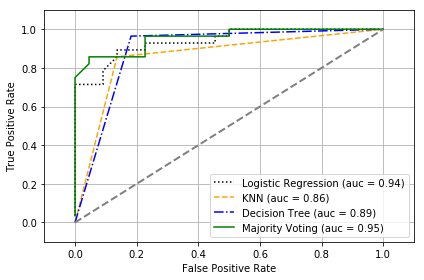

In [27]:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

colors = ['black', 'orange', 'blue', 'green']
linestyles = [':', '--', '-.', '-']
#模型在all_clf里
for clf, label, clr, ls in zip(all_clf, clf_labels, colors, linestyles):

    # assuming the label of the positive class is 1
    # 假设正例的标签是1
    y_pred = clf.fit(X_train, y_train).predict_proba(X_test)[:, 1]
    fpr, tpr, thresholds = roc_curve(y_true=y_test, 
                                     y_score=y_pred)
    roc_auc = auc(x=fpr, y=tpr)
    plt.plot(fpr, tpr, 
             color=clr, 
             linestyle=ls, 
             label='%s (auc = %0.2f)' % (label, roc_auc))

plt.legend(loc='lower right')
plt.plot([0, 1], [0, 1], 
         linestyle='--', 
         color='gray', 
         linewidth=2)

plt.xlim([-0.1, 1.1])
plt.ylim([-0.1, 1.1])
plt.grid()
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

plt.tight_layout()
# plt.savefig('./figures/roc.png', dpi=300)

ROC 可看出, ensemble classfifier 在 test set 上表现不错

对比决策边界

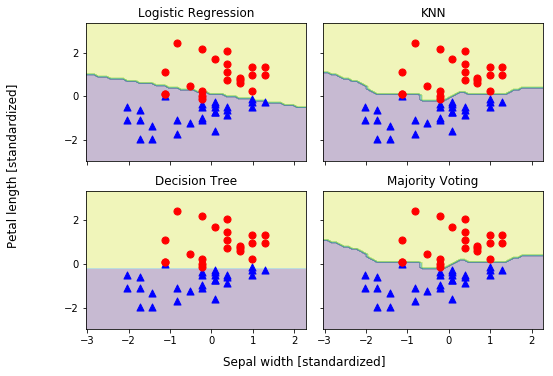

In [28]:
from itertools import product
import numpy as np

x_min = X_train[:, 0].min() - 1
x_max = X_train[:, 0].max() + 1
y_min = X_train[:, 1].min() - 1
y_max = X_train[:, 1].max() + 1

xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                     np.arange(y_min, y_max, 0.1))

# 添加 subplots
f, axarr = plt.subplots(nrows=2, ncols=2, 
                        sharex='col', sharey='row', 
                        figsize=(7, 5))

for idx, clf, tt in zip(product([0, 1], [0, 1]),all_clf, clf_labels):
    clf.fit(X_train, y_train)
    Z = clf.predict(np.vstack([xx.ravel(), yy.ravel()]).T)
    Z = Z.reshape(xx.shape)

    axarr[idx[0], idx[1]].contourf(xx, yy, Z, alpha=0.3)
    axarr[idx[0], idx[1]].scatter(X_train[y_train==0, 0], 
                                  X_train[y_train==0, 1], 
                                  c='blue', marker='^', s=50)
    axarr[idx[0], idx[1]].scatter(X_train[y_train==1, 0], 
                                  X_train[y_train==1, 1], 
                                  c='red', marker='o', s=50)
    axarr[idx[0], idx[1]].set_title(tt)

plt.text(-3.5, -4.5, 
         s='Sepal width [standardized]', 
         ha='center', va='center', fontsize=12)
plt.text(-10.5, 4.5, 
         s='Petal length [standardized]', 
         ha='center', va='center', 
         fontsize=12, rotation=90)

plt.tight_layout()
# plt.savefig('./figures/voting_panel', bbox_inches='tight', dpi=300)

<br>
<br>

决策树的问题：
1. 过拟合（不准）
2. 各种动荡（高方差）


集成方法：
1. 串行(adaboost, gbdt)
2. 并行(randomforest, bagging)

# 通过随机森林将弱分类器组成强分类器

可以看做是 ensemble of decision trees, 将弱的模型结合在一起变成强模型. 更易扩展, 且较少会 overfitting.



1. 有放回抽样，随机自助抽样（bootstrap）抽取大小n的样本
2. 从bootstrap的样本中，建立树，在每个节点：
  - 随机（无放回）选择d个特征
  - 利用这些特征进行最优分裂
3. 重复步骤1和步骤2，k次
4. 最后的预测是每棵树的判断做投票


特点：
1. 行抽样
2. 列抽样
3. 投票

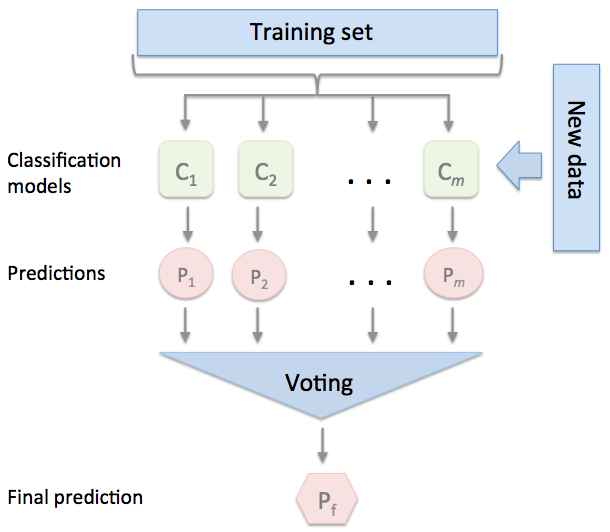

In [2]:
from IPython.display import Image
Image(filename='pic_dir/07_02.png', width=500)

In [4]:
import numpy as np
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

iris = datasets.load_iris()
X = iris.data[:, [2, 3]]
y = iris.target

X_train, X_test, y_train, y_test = train_test_split(
         X, y, test_size=0.3, random_state=0)

sc = StandardScaler()
sc.fit(X_train)
X_train_std = sc.transform(X_train) # standardize by mean & std
X_test_std = sc.transform(X_test)

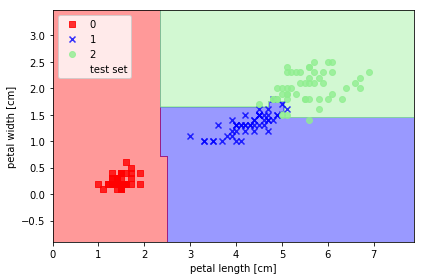

In [9]:
from sklearn.ensemble import RandomForestClassifier
# from 10 decision trees, n_jobs 值使用 cpu 个数
forest = RandomForestClassifier(criterion='entropy',
                                n_estimators=10, 
                                random_state=1,
                                n_jobs=-1)
forest.fit(X_train, y_train)

plot_decision_regions(X_combined, y_combined, 
                      classifier=forest, test_idx=range(105,150))

plt.xlabel('petal length [cm]')
plt.ylabel('petal width [cm]')
plt.legend(loc='upper left')
plt.tight_layout()
# plt.savefig('./figures/random_forest.png', dpi=300)

# 通过adaptive boosting进行集成学习
let the weak learners subsequently learn from misclassified training samples to improve the performance of the ensemble

[[back to top](#目录)]

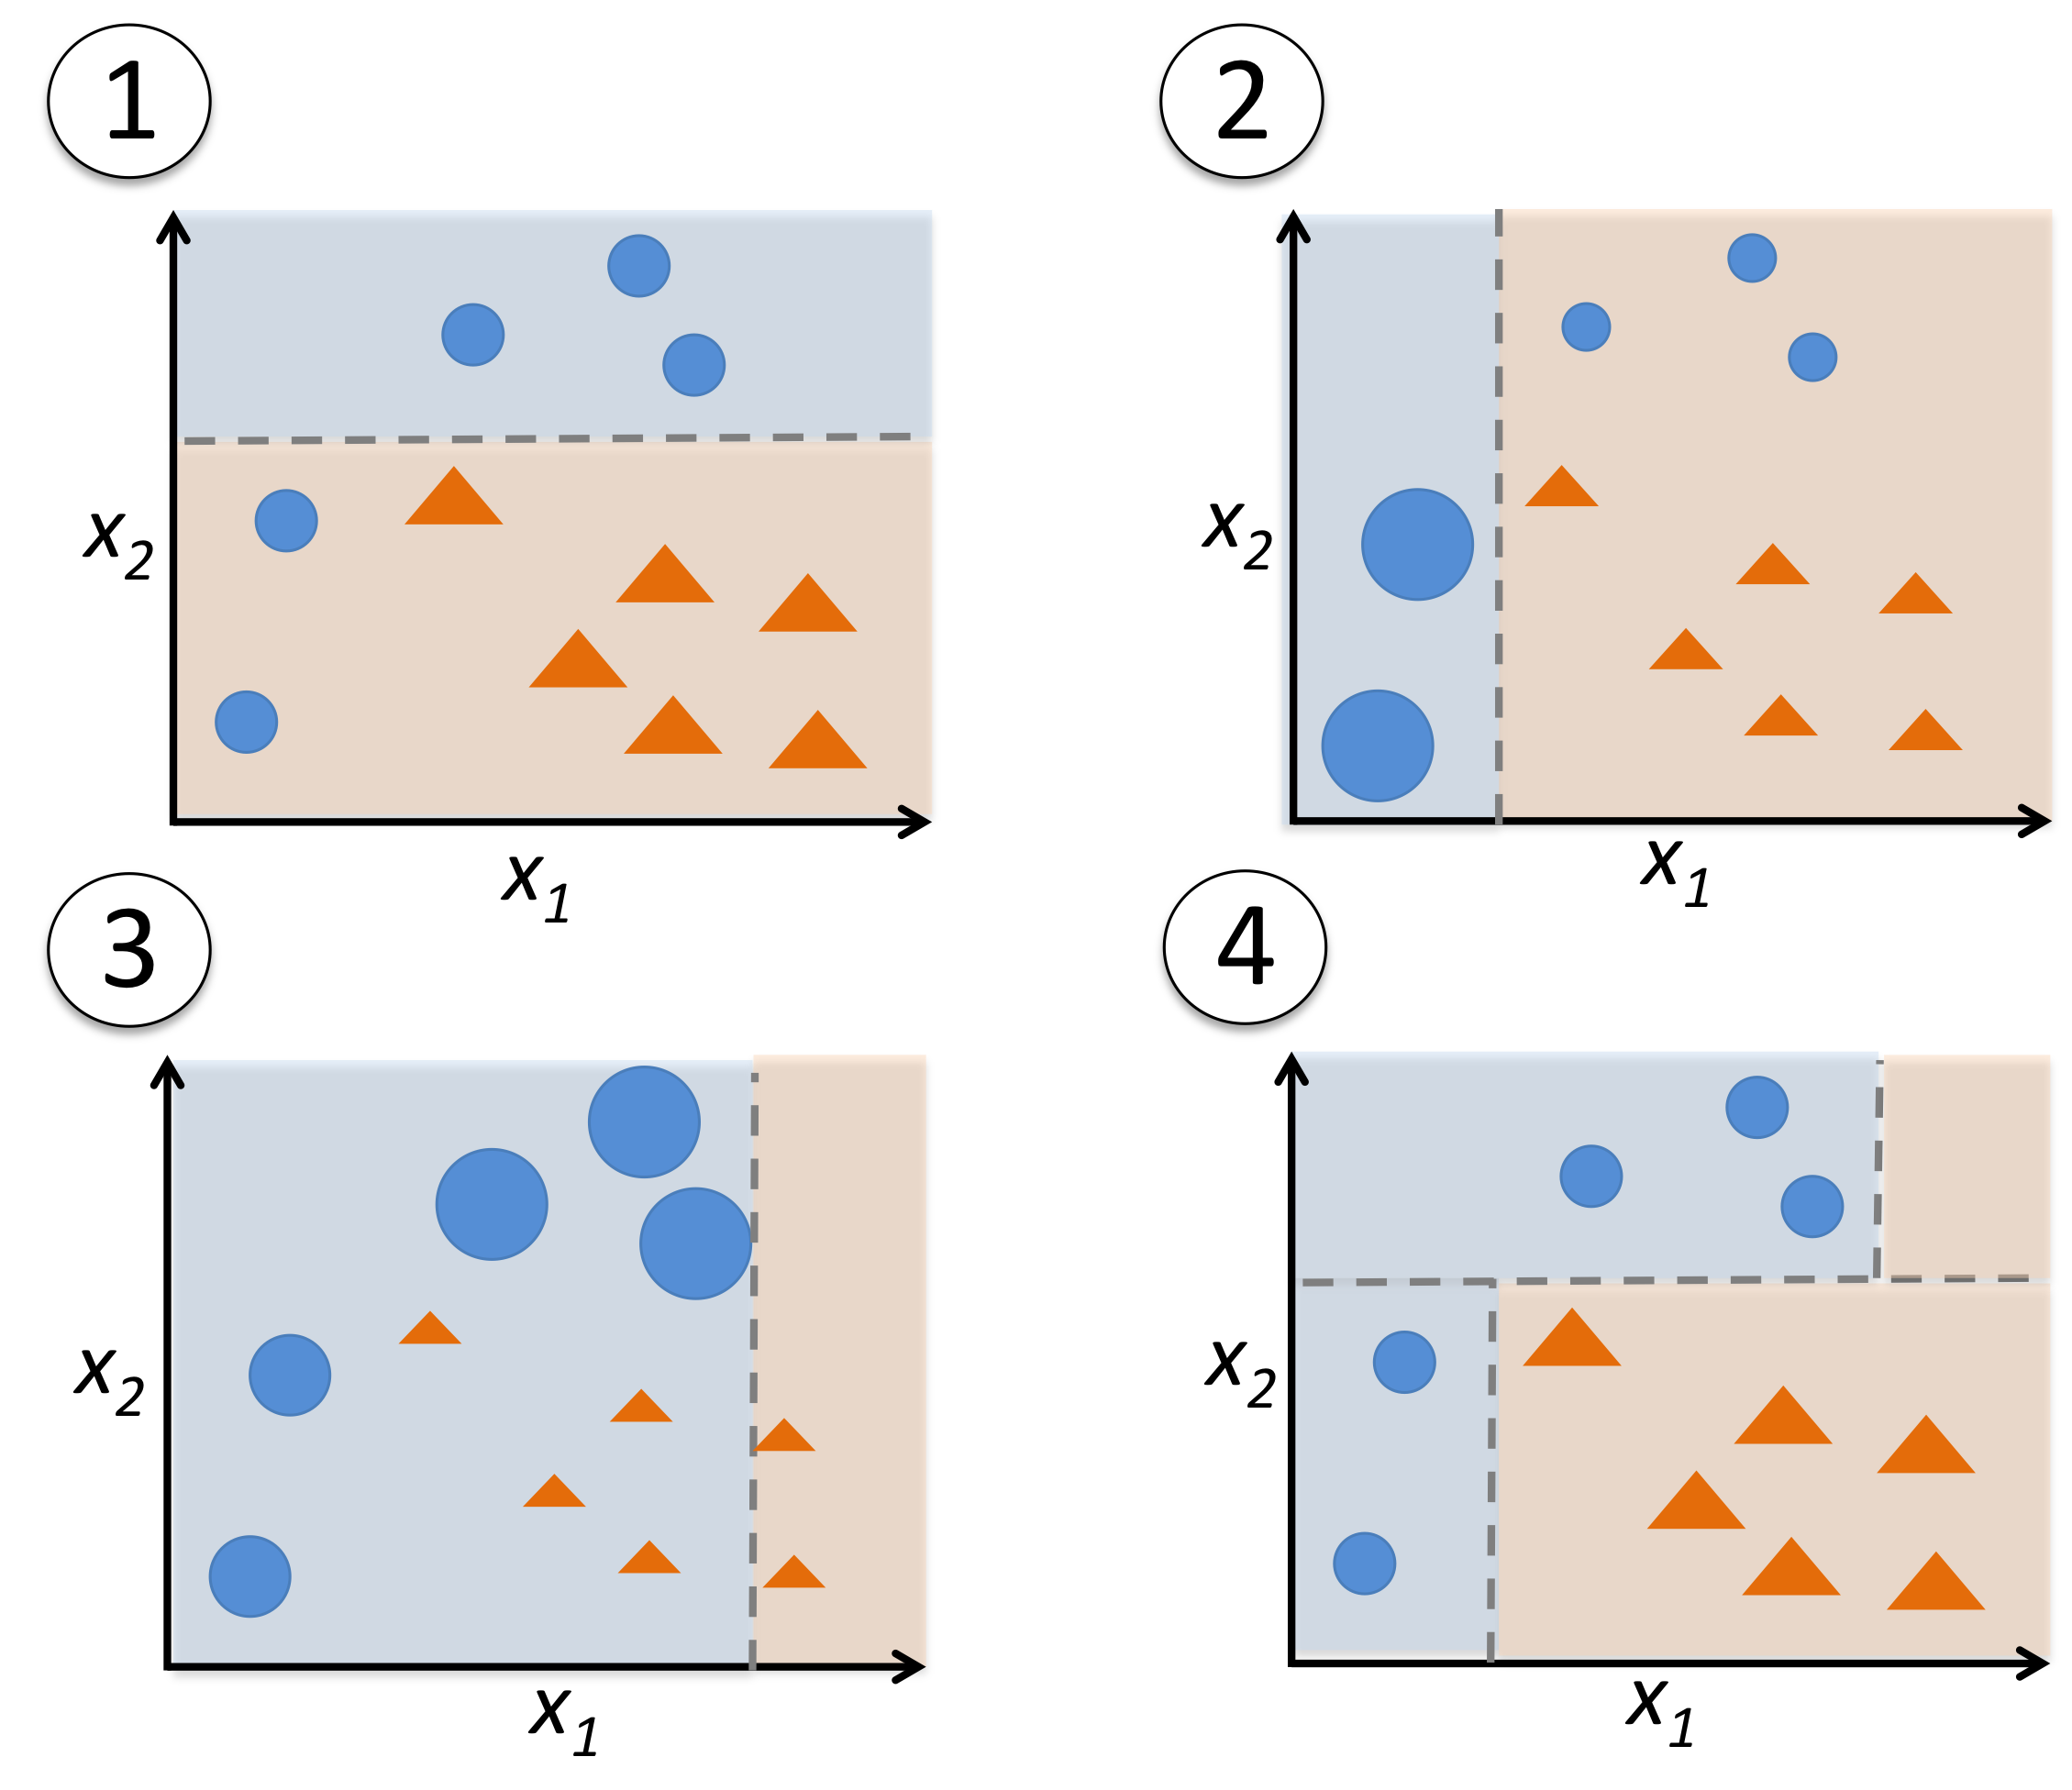

In [29]:
Image(filename='pic_dir/07_09.png', width=500)

Adaptive boosting (AdaBoost)

1. 设置权重向量 w ，其中 $\sum_i w_i = 1$
2. For j in 第m轮 boosting, 进行如下操作:
3. 训练一个带权重的弱学习器: $C_j = train(X,y,w)$.
4. 预测类别标签: $\hat{y} = predict(C_j, X)$ .
5. 计算带权重的error rate: $\epsilon = w \cdot (\hat{y} \neq y)$.
6. 计算系数: $\alpha_j = \frac 1 2 ln\frac{1-\epsilon}{\epsilon}$ .
7. 更新权重: $w:= w \times exp(-\alpha_j \times \hat{y} \times y)$ .
8. 归一化权重: $w:= \frac{w}{\sum_i w_i}$ .
9. 计算最终预测: $\hat{y} = (\sum_{j=1}^{m}(\alpha_j \times predict(C_j, X))>0)$.

$\cdot$ 表示两向量的点积  
$\times$ 表示两向量hadamard积

In [30]:
import pandas as pd
import numpy as np
from sklearn import datasets
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
%matplotlib inline

# wine dataset
df_wine = pd.read_csv('data/wine.data', header=None)

df_wine.columns = ['Class label', 'Alcohol', 'Malic acid', 'Ash', 
'Alcalinity of ash', 'Magnesium', 'Total phenols', 
'Flavanoids', 'Nonflavanoid phenols', 'Proanthocyanins', 
'Color intensity', 'Hue', 'OD280/OD315 of diluted wines', 'Proline']

# 只考虑类别2和类别3
df_wine = df_wine[df_wine['Class label'] != 1]

In [31]:
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
# 转换 label
y = df_wine['Class label'].values
X = df_wine[['Alcohol', 'Hue']].values
le = LabelEncoder()
y = le.fit_transform(y)
y = np.where(y==0,-1,1)
# 60% train, 40% test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.40, random_state=1)

In [32]:
def get_error_rate(pred, Y):
    return sum(pred != Y) / float(len(Y))

def print_error_rate(err):
    print('Error rate: Training: %.4f - Test: %.4f' % err)

#一般的模型（未进行adaboost）
def generic_clf(Y_train, X_train, Y_test, X_test, clf):
    clf.fit(X_train,Y_train)
    pred_train = clf.predict(X_train)
    pred_test = clf.predict(X_test)
    return get_error_rate(pred_train, Y_train), \
           get_error_rate(pred_test, Y_test)

def adaboost_clf(Y_train, X_train, Y_test, X_test, M, clf):
    n_train, n_test = len(X_train), len(X_test)
    # 初始化权重
    w = np.ones(n_train) / n_train
    pred_train, pred_test = [np.zeros(n_train), np.zeros(n_test)]
    
    for i in range(M):
        # 利用指定的权重训练分类器
        clf.fit(X_train, Y_train, sample_weight = w)
        pred_train_i = clf.predict(X_train)
        pred_test_i = clf.predict(X_test)
        # Indicator function示性函数
        miss = [int(x) for x in (pred_train_i != Y_train)]
        # Equivalent with 1/-1 to update weights
        miss2 = [x if x==1 else -1 for x in miss]
        # Error
        err_m = np.dot(w,miss) / sum(w)
        # 计算系数：Alpha
        alpha_m = 0.5 * np.log( (1 - err_m) / float(err_m))
        # 新的权重
        w = w * np.exp([float(x) * alpha_m for x in miss2])
        # Add to prediction
        pred_train = [sum(x) for x in zip(pred_train, 
                                          [x * alpha_m for x in pred_train_i])]
        pred_test = [sum(x) for x in zip(pred_test, 
                                         [x * alpha_m for x in pred_test_i])]
        #print(alpha_m,err_m)
    
    pred_train, pred_test = np.sign(pred_train), np.sign(pred_test)
    # Return error rate in train and test set
    return get_error_rate(pred_train, Y_train), get_error_rate(pred_test, Y_test)

In [33]:
# Fit a simple decision tree first
clf_tree = DecisionTreeClassifier(max_depth = 1, random_state = 1)
er_tree = generic_clf(y_train, X_train, y_test, X_test, clf_tree)
print(er_tree)

(0.11267605633802817, 0.10416666666666667)


In [34]:
adaboost_clf(y_train, X_train, y_test, X_test, 10, clf_tree)

(0.014084507042253521, 0.083333333333333329)

#### 使用scikit进行实现：

In [35]:
from sklearn.ensemble import AdaBoostClassifier

tree = DecisionTreeClassifier(criterion='entropy', 
                              max_depth=1)

ada = AdaBoostClassifier(base_estimator=tree,
                         n_estimators=500, 
                         learning_rate=0.1,
                         random_state=0)

In [36]:
df_wine = pd.read_csv('data/wine.data', 
                      header=None)

df_wine.columns = ['Class label', 'Alcohol', 'Malic acid', 'Ash', 
'Alcalinity of ash', 'Magnesium', 'Total phenols', 
'Flavanoids', 'Nonflavanoid phenols', 'Proanthocyanins', 
'Color intensity', 'Hue', 'OD280/OD315 of diluted wines', 'Proline']

# only consider Wine classes 2 and 3
df_wine = df_wine[df_wine['Class label'] != 1]

y = df_wine['Class label'].values
X = df_wine[['Alcohol', 'Hue']].values
le = LabelEncoder()
y = le.fit_transform(y)
X_train, X_test, y_train, y_test = \
    train_test_split(X, y, test_size=0.40, random_state=1)

tree = tree.fit(X_train, y_train)
y_train_pred = tree.predict(X_train)
y_test_pred = tree.predict(X_test)

tree_train = accuracy_score(y_train, y_train_pred)
tree_test = accuracy_score(y_test, y_test_pred)
print('Decision tree train/test accuracies %.3f/%.3f'
      % (tree_train, tree_test))

ada = ada.fit(X_train, y_train)
y_train_pred = ada.predict(X_train)
y_test_pred = ada.predict(X_test)

ada_train = accuracy_score(y_train, y_train_pred) 
ada_test = accuracy_score(y_test, y_test_pred) 
print('AdaBoost train/test accuracies %.3f/%.3f'
      % (ada_train, ada_test))

Decision tree train/test accuracies 0.845/0.854
AdaBoost train/test accuracies 1.000/0.875


Adaboost 可以减少 Bias，但可能引入更多的 Variance

看看决策边界

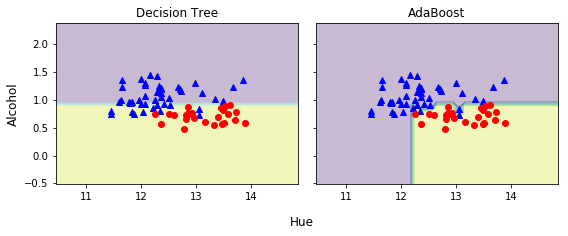

In [37]:
x_min, x_max = X_train[:, 0].min() - 1, X_train[:, 0].max() + 1
y_min, y_max = X_train[:, 1].min() - 1, X_train[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                     np.arange(y_min, y_max, 0.1))

f, axarr = plt.subplots(1, 2, sharex='col', sharey='row', figsize=(8, 3))


for idx, clf, tt in zip([0, 1],
                        [tree, ada],
                        ['Decision Tree', 'AdaBoost']):
    clf.fit(X_train, y_train)

    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    axarr[idx].contourf(xx, yy, Z, alpha=0.3)
    axarr[idx].scatter(X_train[y_train == 0, 0],
                       X_train[y_train == 0, 1],
                       c='blue', marker='^')
    axarr[idx].scatter(X_train[y_train == 1, 0],
                       X_train[y_train == 1, 1],
                       c='red', marker='o')
    axarr[idx].set_title(tt)

axarr[0].set_ylabel('Alcohol', fontsize=12)
plt.text(10.2, -1.2,
         s='Hue',
         ha='center', va='center', fontsize=12)

plt.tight_layout()
# plt.savefig('./figures/adaboost_region.png',
#           dpi=300,
#           bbox_inches='tight')
plt.show()

<br>
<br>

# 其它算法实现（手动实现的参考）

[[back to top](#目录)]

In [ ]:
xgboost  --- gbm  ---- adaboost(ensemble learning)

集成学习的研究核心：

1. 弱分类器如何产生
2. 弱分类器如何结合


结合方式：

1. 串行生成（存在强依赖）
2. 并行生成（不存在强依赖）

提升树：多个小树，逐步补偿上个模型的残差

---> 梯度提升树（GBM）

### 广义提升树算法详解

In [147]:
import numpy
import matplotlib.pyplot as plot
%matplotlib inline
from sklearn import tree
from sklearn.tree import DecisionTreeRegressor
from math import floor
import random

In [148]:
# Build a simple data set with y = x + random
n_points = 1000

# x values for plotting
x_plot = [(float(i) / float(n_points) - 0.5) for i in range(n_points + 1)]

# x needs to be list of lists.
x = [[s] for s in x_plot]

# y (labels) has random noise added to x-value
# set seed
numpy.random.seed(1)
y = [s + numpy.random.normal(scale=0.1) for s in x_plot]

# take fixed test set 30% of sample
n_sample = int(n_points * 0.30)
idx_test = random.sample(range(n_points), n_sample)
idx_test.sort()
idx_train = [idx for idx in range(n_points) if not (idx in idx_test)]

# Define test and training attribute and label sets
x_train = [x[r] for r in idx_train]
x_test = [x[r] for r in idx_test]
y_train = [y[r] for r in idx_train]
y_test = [y[r] for r in idx_test]


In [151]:

# train a series of models on random subsets of the training data
# collect the models in a list and check error of composite as list grows

# maximum number of models to generate
num_trees_max = 30

# tree depth - typically at the high end
tree_depth = 5

# initialize a list to hold models
mode_list = []
pred_list = []
eps = 0.3

# initialize residuals to be the labels y
residuals = list(y_train)

for i_trees in range(num_trees_max):
    mode_list.append(DecisionTreeRegressor(max_depth=tree_depth))
    mode_list[-1].fit(x_train, residuals)

    # make prediction with latest model and add to list of predictions
    latest_in_sample_prediction = mode_list[-1].predict(x_train)

    # use new predictions to update residuals
    residuals = [residuals[i] - eps * latest_in_sample_prediction[i]
                 for i in range(len(residuals))]

    latest_out_sample_prediction = mode_list[-1].predict(x_test)
    pred_list.append(list(latest_out_sample_prediction))

# build cumulative prediction from first "n" models
mse = []
all_predictions = []
for i_models in range(len(mode_list)):

    # add the first "i_models" of the predictions and multiply by eps
    prediction = []
    for i_pred in range(len(x_test)):
        prediction.append(
            sum([pred_list[i][i_pred] for i in range(i_models + 1)]) * eps)

    all_predictions.append(prediction)
    errors = [(y_test[i] - prediction[i]) for i in range(len(y_test))]
    mse.append(sum([e * e for e in errors]) / len(y_test))

n_models = [i + 1 for i in range(len(mode_list))]

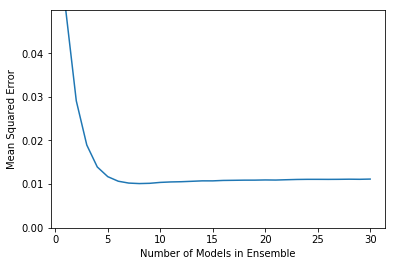

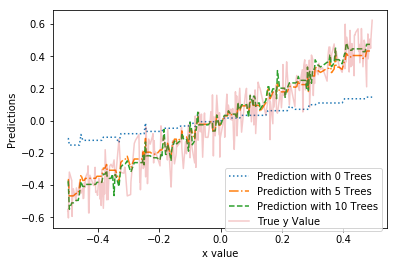

In [160]:
plot.plot(n_models, mse)
plot.axis('tight')
plot.xlabel('Number of Models in Ensemble')
plot.ylabel('Mean Squared Error')
plot.ylim((0.0, max(mse)))
plot.show()

plot_list = [0, 5, 10]
line_type = [':', '-.', '--']
plot.figure()
for i in range(len(plot_list)):
    i_plot = plot_list[i]
    text_legend = 'Prediction with ' + str(i_plot) + ' Trees'
    plot.plot(x_test, all_predictions[i_plot], label=text_legend,
              linestyle=line_type[i])
plot.plot(x_test, y_test,label='True y Value', alpha=0.25)
plot.legend(bbox_to_anchor=(1, 0.3))
plot.axis('tight')
plot.xlabel('x value')
plot.ylabel('Predictions');

<br>
<br>

#### sklearn实现：

In [19]:
from sklearn.ensemble import GradientBoostingRegressor

clf = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1,
    max_depth=1, random_state=0, loss='ls').fit(x_train, y_train)

In [155]:
clf.score(x_test, y_test)

0.8937191031530749

### 随机森林算法详解

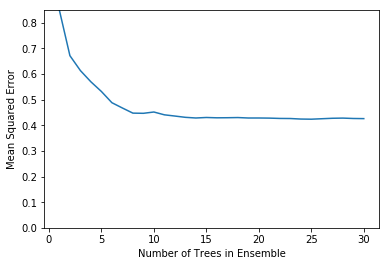

Minimum MSE
0.423659098066


In [20]:
import numpy
from sklearn import tree
from sklearn.tree import DecisionTreeRegressor
import random
from math import sqrt
import matplotlib.pyplot as plot

# read data into iterable
target_url = "data/winequality-red.csv"
data = open(target_url)

x_list = []
labels = []
names = []
first_line = True
for line in data:
    if first_line:
        names = line.strip().split(";")
        first_line = False
    else:
        # split on semi-colon
        row = line.strip().split(";")
        # put labels in separate array
        labels.append(float(row[-1]))
        # remove label from row
        row.pop()
        # convert row to floats
        float_row = [float(num) for num in row]
        x_list.append(float_row)

nrows = len(x_list)
ncols = len(x_list[0])

# take fixed test set 30% of sample
random.seed(1)  # set seed so results are the same each run
n_sample = int(nrows * 0.30)
idx_test = random.sample(range(nrows), n_sample)
idx_test.sort()
idx_train = [idx for idx in range(nrows) if not (idx in idx_test)]

# Define test and training attribute and label sets
x_train = [x_list[r] for r in idx_train]
x_test = [x_list[r] for r in idx_test]
y_train = [labels[r] for r in idx_train]
y_test = [labels[r] for r in idx_test]

# train a series of models on random subsets of the training data
# collect the models in a list and check error of composite as list grows

# maximum number of models to generate
num_trees_max = 30

# tree depth - typically at the high end
tree_depth = 12

# pick how many attributes will be used in each model.
# authors recommend 1/3 for regression problem
n_attr = 4

# initialize a list to hold models
mode_list = []
index_list = []
pred_list = []
n_train_rows = len(y_train)

for i_trees in range(num_trees_max):

    mode_list.append(DecisionTreeRegressor(max_depth=tree_depth))

    # take random sample of attributes
    idx_attr = random.sample(range(ncols), n_attr)
    idx_attr.sort()
    index_list.append(idx_attr)

    # take a random sample of training rows
    idx_rows = []
    for i in range(int(0.5 * n_train_rows)):
        idx_rows.append(random.choice(range(len(x_train))))
    idx_rows.sort()

    # build training set
    x_rf_train = []
    y_rf_train = []

    for i in range(len(idx_rows)):
        temp = [x_train[idx_rows[i]][j] for j in idx_attr]
        x_rf_train.append(temp)
        y_rf_train.append(y_train[idx_rows[i]])

    mode_list[-1].fit(x_rf_train, y_rf_train)

    # restrict xTest to attributes selected for training
    x_rf_test = []
    for xx in x_test:
        temp = [xx[i] for i in idx_attr]
        x_rf_test.append(temp)

    latest_out_sample_prediction = mode_list[-1].predict(x_rf_test)
    pred_list.append(list(latest_out_sample_prediction))

# build cumulative prediction from first "n" models
mse = []
all_predictions = []
for i_models in range(len(mode_list)):

    # add the first "iModels" of the predictions and multiply by eps
    prediction = []
    for i_pred in range(len(x_test)):
        prediction.append(
            sum([pred_list[i][i_pred] for i in range(i_models + 1)]) / (
            i_models + 1))

    all_predictions.append(prediction)
    errors = [(y_test[i] - prediction[i]) for i in range(len(y_test))]
    mse.append(sum([e * e for e in errors]) / len(y_test))

n_models = [i + 1 for i in range(len(mode_list))]

plot.plot(n_models, mse)
plot.axis('tight')
plot.xlabel('Number of Trees in Ensemble')
plot.ylabel('Mean Squared Error')
plot.ylim((0.0, max(mse)))
plot.show()

print('Minimum MSE')
print(min(mse))

![ml_map](./pic/ml_map.png)

<br>
<br>

<br>
<br>